<a href="https://colab.research.google.com/github/Anisnisa/SKRIPSI/blob/main/GridCV_Anis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings; warnings.simplefilter('ignore'); warnings.filterwarnings('ignore', module='darts'); warnings.filterwarnings('ignore', module='pandas')
import numpy as np, darts, sys, pandas as pd
from darts import metrics

SEED = 0


In [3]:
pip install dysts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Loading Contoh Data dari Dysts
from dysts.datasets import load_dataset

data = 'Sakarya'
train_ = load_dataset(subsets="train", data_format="pandas", univariate=True).loc[data]
test_ = load_dataset(subsets="test", data_format="pandas", univariate=True).loc[data] #kenapa dibagi disini pada di bawah juga dibagi lagi, apakah memang sudah dari sananya dibagi

df = pd.concat([train_, test_], axis=0).reset_index()
# Hati-hati versi terbaru harus "reset_index" kalau ndak cell selanjutnya error
print(df.shape)
df.head() 



(2000, 4)


,index,id,time,values
0,Sakarya,89.0,0.000000,1.371272
1,Sakarya,89.0,0.049886,1.346195
2,Sakarya,89.0,0.099771,1.312314
3,Sakarya,89.0,0.149657,1.272231
4,Sakarya,89.0,0.199542,1.228115


1900 100


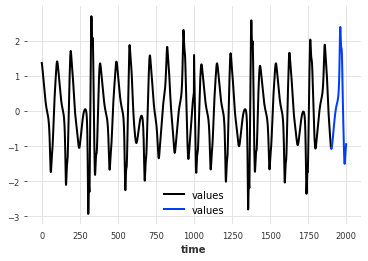

In [5]:
#Transform "Pandas Dataframe" ke "Darts Series"
def df2series(df, cols):
    for i, col in enumerate(df[cols].columns):
        if i==0:
            series = darts.TimeSeries.from_dataframe(df, time_col=None, value_cols=col)
        else:
            series = series.stack(darts.TimeSeries.from_dataframe(df, time_col=None, value_cols=col))
    return series

cols = ['values'] # Silahkan rename jadi x, y, z


data = df2series(df, cols)
train, test = data.split_after(0.95)
print(len(train), len(test))
train['values'].plot()
test['values'].plot()




In [6]:
from darts.models import RandomForest

def RF(data, model, pVal=0.1, n_jobs=4, verbose_=False, metric_='smape'):
    # https://unit8co.github.io/darts/generated_api/darts.models.forecasting.random_forest.html
    parameters = {
        "lags": (range(2,13)), # list(range(2, 13)),
        "output_chunk_length" : [1, 2, 3, 4, 5, 10, 15, 16],
        "n_estimators":[10, 25, 50], # list(range(10,110,10))
        "random_state":[SEED],}

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [16]:
smape = []
rmse =[]

for x,y in enumerate(data):
  data = x + y
  if y < 600:
    model, bestparams, bestMetric_ = RF(x, RandomForest)
    print("BestParameters", bestparams)
    print("bestMetric_", bestMetric_)
    # ===================== Training, Forecast & BackTest for Cross Validation=============================
    print("GridSearch Finished,Training Best Model ... ", flush=True)
    model.fit(x)
    forecast_ = model.predict(len(y))
    del model 
    smape.append(darts.metrics.smape(y, forecast_))
    rmse.append(darts.metrics.rmse(y, forecast_))
    y =- 5
  else:
    print("selesai")


AttributeError: ignored

In [19]:
model, bestparams, bestMetric_ = RF(train, RandomForest)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric_)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast_ = model.predict(len(test))
del model 
smape_ = darts.metrics.smape(test, forecast_)
rmse_ = darts.metrics.rmse(test, forecast_)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'lags': 10, 'output_chunk_length': 15, 'n_estimators': 25, 'random_state': 0}
bestMetric_ 60.4476401875559
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.4059693872724611, sMAPE=34.96323211412177 


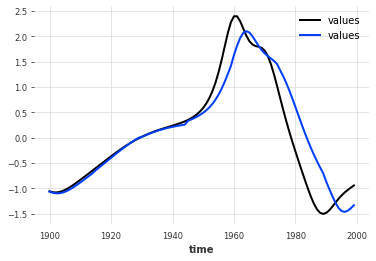

In [20]:
test['values'].plot()
forecast_['values'].plot()

In [21]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(data, start=.95, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [22]:
smape_ = darts.metrics.smape(data, backTest)
rmse_ = darts.metrics.rmse(data, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.2552725584295239, sMAPE=31.087188906033436 


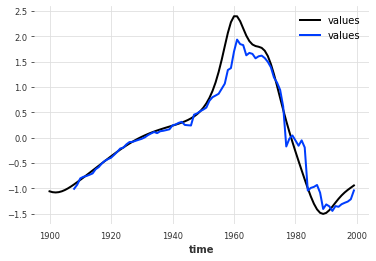

In [23]:
test['values'].plot()
backTest['values'].plot()